In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import yaml
import time
from tqdm import tqdm

from erpe.analysis import *
from erpe.experiment_design import *
from erpe.models import *
from erpe.qcal_util import *
from erpe.lqr import *

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

In [2]:
import qcal as qc

from qcal.units import *
from qcal.utils import load_from_pickle
from qcal.backend.qubic.qpu import QubicQPU
from qcal.backend.qubic.utils import qubic_sequence

from qcal.benchmarking.readout import ReadoutFidelity
from qcal.calibration.readout import ReadoutCalibration

from qcal.interface.pygsti.circuits import load_circuits
from qcal.interface.pygsti.transpiler import Transpiler
from qcal.interface.pygsti.datasets import generate_pygsti_dataset

In [3]:
import qcal.settings as settings

logger = logging.getLogger(__name__)

basedir = '/home/jpmarceaux/experiment/'
settings.Settings.config_path = basedir + 'config/'
settings.Settings.data_path = basedir + 'data/'
settings.Settings.save_data = True

#cfg = qc.Config()
akel_config = qc.Config(basedir + 'config/configs/X6Y3/config.yaml')
classifier = load_from_pickle(basedir + 'config/configs/X6Y3/ClassificationManager.pkl')
# cfg = qc.Config(basedir + 'config/Campbell06/X6Y3/config_abhi.yaml')
akel_config.draw_qpu()

In [5]:
from qcal.characterization.coherence import T1, T2


In [25]:
def run_t1(qid, config):
    akel_config.load()

    qubits = (qid[1],)
    print(qubits)
    n_elements = 50
    char1 = T1(
        QubicQPU,
        config,
        qubits,
        t_max=500*us,
        classifier=classifier,
        n_elements=n_elements,
        n_circs_per_seq=n_elements,
        reload_freq=False,
        reload_env=False,
        zero_between_reload=False
    )
    char1.run()
    res = char1._char_values[qid[1]]
    return res

In [29]:
run_t1('Q0', akel_config)

INFO:qcal.characterization.coherence: Generating circuits...
INFO:QPU: No batching...
INFO:QPU: Generating sequences...


('0',)


UnboundLocalError: cannot access local variable 'qubits' where it is not associated with a value

In [30]:
debug

> /home/jpmarceaux/qcal/qcal/backend/qubic/transpiler.py(237)add_measurement()
    235     # Barrier before readout
    236     meas_pulse.append(
--> 237         {'name': 'barrier', 'qubit': [f'Q{q}' for q in qubits]}
    238     )
    239 



*** NameError: name 'qubits' is not defined
*** NameError: name 'qubits' is not defined
> /home/jpmarceaux/qcal/qcal/backend/qubic/transpiler.py(184)add_heralding()
    182     """
    183     for q in qubits:
--> 184         add_measurement(config, q, circuit, pulses)
    185 
    186     circuit.extend((

('0',)


INFO:QPU: Data save location: /home/jpmarceaux/experiment/data/2024-11-08/20241108_123848_T1_Q1/



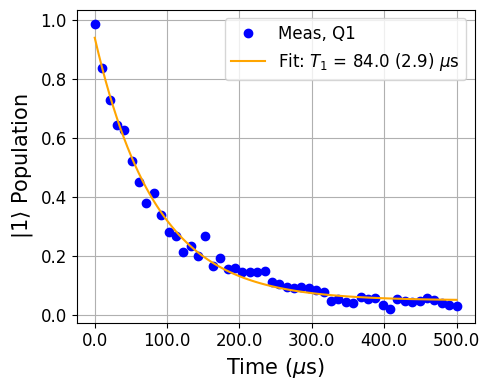

INFO:qcal.config: Param ['single_qubit', 1, 'GE', 'T1'] set to 8.4e-05.



Runtime:   Compile  Transpile  Sequencing  Write  Measure  Process  Total
Time (s)      0.0        0.0         0.2    0.0     63.0      0.1   63.3



In [7]:
akel_config.load()

qubits = (1,)
n_elements = 50
char1 = T1(
      QubicQPU,
      akel_config,
      qubits,
      t_max=500*us,
      classifier=classifier,
      n_elements=n_elements,
      n_circs_per_seq=n_elements,
      reload_freq=False,
      reload_env=False,
      zero_between_reload=False
  )
char1.run()

INFO:QPU: Data save location: /home/jpmarceaux/experiment/data/2024-11-08/20241108_124525_T2_Q0/



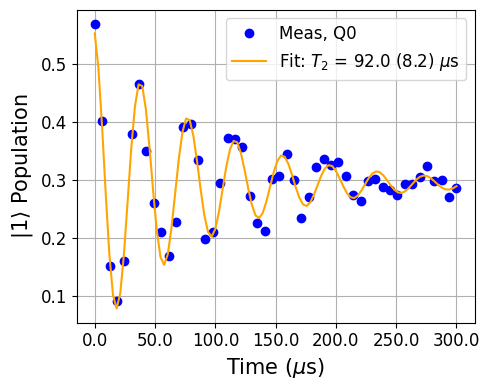

INFO:qcal.config: Param ['single_qubit', 0, 'GE', 'T2*'] set to 9.2e-05.



Runtime:   Compile  Transpile  Sequencing  Write  Measure  Process  Total
Time (s)      0.0        0.0         0.2    0.0     51.8      0.1   52.0



In [23]:
akel_config.load()

qubits = (0,)
n_elements = 50
char = T2(
      QubicQPU,
      akel_config,
      qubits,
      t_max=300*us,
      echo=False,
      detuning=25*kHz,
      classifier=classifier,
      n_elements=n_elements,
      n_circs_per_seq=n_elements,
      reload_freq=False,
      reload_env=False,
      zero_between_reload=False
  )
char.run()

In [24]:
char._char_values

{0: 9.2e-05}

In [17]:
char1?

Type:           T1
String form:    <qcal.characterization.coherence.T1.<locals>.T1 object at 0x70a6c8b7c350>
File:           ~/qcal/qcal/characterization/coherence.py
Docstring:     
T1 characterization class.

This class inherits a custom QPU from the T1 characterization
function.
Init docstring: Initialize the T1 experiment class within the function.

In [20]:
char1._char_values[1]

8.4e-05

In [16]:
def run_ramsey_rpe(qid, config, depths, num_shots_per_circuit, classifier):
    edesign_ramsey = EDesign_Ramsey(depths, [qid])
    ds_0_ramsey = make_dataset(config, edesign_ramsey, num_shots_per_circuit, classifier)
    analysis_ramsey0 = Analysis_Ramsey(ds_0_ramsey, edesign_ramsey)
    return ds_0_ramsey, analysis_ramsey0

def run_xgate_rpe(qid, config, depths, num_shots_per_circuit, classifier):
    edesign_xgate = EDesign_Xgate(depths, [qid])
    ds_0_xgate = make_dataset(config, edesign_xgate, num_shots_per_circuit, classifier)
    analysis_xgate0 = Analysis_Xgate(ds_0_xgate, edesign_xgate)
    return ds_0_xgate, analysis_xgate0

def run_cz_rpe(qids, config, depths, num_shots_per_circuit, classifier):
    edesign_cz = EDesign_CZ(depths, qids)
    ds_0_cz = make_dataset(config, edesign_cz, num_shots_per_circuit, classifier)
    analysis_cz0 = Analysis_CZ(ds_0_cz, edesign_cz)
    return ds_0_cz, analysis_cz0


In [18]:
depths_ramsey = [2**i for i in range(12)]
depths_xgate = [2**i for i in range(9)]
depths_cz = [2**i for i in range(6)]
num_shots_per_circuit = 1000



In [6]:
ds_ramsey, analysis_ramsey = run_ramsey_rpe('Q0', akel_config, depths_ramsey, 1000, classifier)

Reading /home/jpmarceaux/experiment/data/2024-11-06/20241106_144119/RPE_dataset.txt: 100%


In [14]:
ds_xgate, analysis_xgate = run_xgate_rpe('Q0', akel_config, depths_xgate, 1000, classifier)


Reading /home/jpmarceaux/experiment/data/2024-11-06/20241106_144325/RPE_dataset.txt: 100%


In [19]:
ds_cz, analysis_cz = run_cz_rpe(['Q0', 'Q1'], akel_config, depths_cz, 1000, classifier)

Reading /home/jpmarceaux/experiment/data/2024-11-06/20241106_144605/RPE_dataset.txt: 100%


In [22]:
pwd

'/home/jpmarceaux/longtime_stability'

In [27]:
pygsti.io.write_dataset('drift_characterization_experiments/nov6_2024/test.txt', ds_ramsey)

In [25]:
ds_cz.write_binary('drift_characterization_experiments/nov6_2024/test')

In [21]:
(50*6 + 34*2)/60

6.133333333333334

In [15]:
print(analysis_ramsey.estimates)
print(analysis_xgate.estimates)
print(analysis_cz.estimates)

{'idle': -0.000141777562297829}
{'X overrot': 0.302797777123069, 'X axis': 0.0018468508262805311}


In [28]:
import pickle

In [30]:
import time

In [35]:
# long-term data collection
qids_1qb = ['Q0', 'Q1', 'Q2']
qids_CZ = [('Q0', 'Q1'), ('Q1', 'Q2')]

while(True):
    # run ramsey on the qubits
    for qid in qids_1qb:
        timestamp = time.time()
        ds_ramsey, analysis_ramsey = run_ramsey_rpe(qid, akel_config, depths_ramsey, 1000, classifier)
        pygsti.io.write_dataset(f'drift_characterization_experiments/nov6_2024/{qid}_ramsey_{timestamp}.txt', ds_ramsey)
        # pickle the anlaysis 
        with open(f'drift_characterization_experiments/nov6_2024/{qid}_ramsey_{timestamp}.pkl', 'wb') as f:
            pickle.dump(analysis_ramsey, f)
    # run xgate on the qubits
    for qid in qids_1qb:
        timestamp = time.time()
        ds_xgate, analysis_xgate = run_xgate_rpe(qid, akel_config, depths_xgate, 1000, classifier)
        pygsti.io.write_dataset(f'drift_characterization_experiments/nov6_2024/{qid}_xgate_{timestamp}.txt', ds_xgate)
        # pickle the anlaysis 
        with open(f'drift_characterization_experiments/nov6_2024/{qid}_xgate_{timestamp}.pkl', 'wb') as f:
            pickle.dump(analysis_xgate, f)
    # run cz on the qubits
    for qids in qids_CZ:
        timestamp = time.time()
        ds_cz, analysis_cz = run_cz_rpe(qids, akel_config, depths_cz, 1000, classifier)
        pygsti.io.write_dataset(f'drift_characterization_experiments/nov6_2024/{qids[0]}_{qids[1]}_cz_{timestamp}.txt', ds_cz)
        # pickle the anlaysis 
        with open(f'drift_characterization_experiments/nov6_2024/{qids[0]}_{qids[1]}_cz_{timestamp}.pkl', 'wb') as f:
            pickle.dump(analysis_cz, f)
    # wait 10 minutes
    time.sleep(600)
    


Reading /home/jpmarceaux/experiment/data/2024-11-06/20241106_145813/RPE_dataset.txt: 100%


INFO:qcal.config: Param ['readout', 'esp', 'enable'] set to False.
INFO:QPU: No batching...
INFO:QPU: Generating sequences...
INFO:QPU: Writing sequences...
INFO:QPU: Measuring...
